# Import Modules

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
import torch.nn as nn
from tqdm.auto import tqdm
import time
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

# Import Dataset

In [88]:
df = pd.read_csv("movies_new.csv")
df = df.sort_values(by="startYear")
print(f"Features: {df.columns}")
print(f"Shape: {df.shape}")

Features: Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'HitScore'],
      dtype='object')
Shape: (199595, 11)


## Data Preprocessing 

#### Feature Engineering

In [89]:
# Convert to list
df['genres_list'] = df['genres'].apply(lambda x: x.split(','))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres_list'])  # Fit & transform genres

genre_columns = mlb.classes_  # Get genre names as column names
df[genre_columns] = genre_encoded  # Add encoded genres to DataFrame

In [90]:
df['isAdult'] = df['isAdult'].astype(int)  
df['numVotes_log'] = np.log1p(df['numVotes'])

df['numVotes_log'] = np.log1p(df['numVotes'])
numeric_columns = ['averageRating', 'HitScore', 'numVotes', 'numVotes_log', 'runtimeMinutes', 'startYear']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
df.loc[:, 'runtimeMinutes'] = df['runtimeMinutes'].fillna(df['runtimeMinutes'].median())
df.drop(columns=["originalTitle"], inplace=True)

# Define features and target
X= df[['averageRating', 'HitScore', 'numVotes_log', 'runtimeMinutes']+ list(genre_columns)].to_numpy()
y = df['HitScore'].to_numpy().reshape(-1,1)

# Split data into training (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split temp (20%) into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"{X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == df.shape[0]}")

True


### Normalize the dataset

In [91]:
scalerX = StandardScaler()
X_train_scaled = scalerX.fit_transform(X_train)  # Fit on training set
X_test_scaled = scalerX.transform(X_test)
X_val_scaled = scalerX.transform(X_val)  # Apply on test set


scalerY = StandardScaler()
y_train_scaled = scalerY.fit_transform(y_train.reshape(-1, 1))  # Fit on training set
y_test_scaled = scalerY.transform(y_test.reshape(-1, 1))  # Apply on test set
y_val_scaled = scalerY.transform(y_val.reshape(-1, 1))  # Apply on validation test set

### Frame as a Time Series problem
* Convert the data into a sequential type

In [92]:
# Define time step (e.g., 5 years)
TIME_STEP = 5  

def create_sequences(X, y, time_step):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        Xs.append(X[i:i+time_step])  # Past 5 years
        ys.append(y[i+time_step])    # Target is the next year
    return np.array(Xs), np.array(ys)

# Convert datasets into 3D shape (samples, time steps, features)
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, TIME_STEP)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, TIME_STEP)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIME_STEP)

# Check shapes
print("Train shape:", X_train_seq.shape)  # (samples, time_steps, features)
print("Val shape:", X_val_seq.shape)
print("Test shape:", X_test_seq.shape)

Train shape: (159671, 5, 31)
Val shape: (19954, 5, 31)
Test shape: (19955, 5, 31)


### Convert to Tensors

In [93]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)


# Check shapes
print(X_train_tensor.shape, y_train_tensor.shape)
print(X_val_tensor.shape, y_val_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([159671, 5, 31]) torch.Size([159671, 1])
torch.Size([19954, 5, 31]) torch.Size([19954, 1])
torch.Size([19955, 5, 31]) torch.Size([19955, 1])


### Use Dataloaders from PyTorch

In [94]:
import os
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 128  

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=os.cpu_count(), shuffle=False)

print(f"Dataloaders:\nTrain dataloader: {train_dataloader}\nTest dataloader: {test_dataloader}\nValidation dataloader: {val_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {val_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"=============================================================================="*100)

Dataloaders:
Train dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f3ceeb0bf80>
Test dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f3cd78dbf80>
Validation dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f3ce87c3da0>
Length of train dataloader: 1248 batches of 128
Length of validation dataloader: 156 batches of 128
Length of test dataloader: 156 batches of 128


# Optimizer

In [95]:
#Adan: Adaptive Nesterov Momentum Algorithm

import math
from typing import List
from torch import Tensor

class MultiTensorApply(object):
    available = False
    warned = False

    def __init__(self, chunk_size):
        try:
            MultiTensorApply.available = True
            self.chunk_size = chunk_size
        except ImportError as err:
            MultiTensorApply.available = False
            MultiTensorApply.import_err = err

    def __call__(self, op, noop_flag_buffer, tensor_lists, *args):
        return op(self.chunk_size, noop_flag_buffer, tensor_lists, *args)


class Adan(torch.optim.Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for
        Faster Optimizing Deep Models[J].arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or
            dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for
            first- and second-order moments. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay
            (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay
            (default: False)
        foreach (bool): if True would use torch._foreach implementation.
            It's faster but uses slightly more memory. (default: True)
        fused (bool, optional): whether fused implementation is used.
            (default: False)
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True,
                 fused: bool = False):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        if fused:
            _check_fused_available()

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach,
                        fused=fused)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            if not params_with_grad:
                continue

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                if group['fused']:
                    if torch.cuda.is_available():
                        _fused_adan_multi_tensor(**kwargs)
                    else:
                        raise ValueError('Fused Adan does not support CPU')
                else:
                    _multi_tensor_adan(**kwargs)
            elif group['fused']:
                if torch.cuda.is_available():
                    _fused_adan_single_tensor(**kwargs)
                else:
                    raise ValueError('Fused Adan does not support CPU')
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_multi_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    import fused_adan
    multi_tensor_applier = MultiTensorApply(2048 * 32)
    _dummy_overflow_buf = torch.cuda.IntTensor([0])
    multi_tensor_applier(
        fused_adan.adan_multi_tensor, _dummy_overflow_buf,
        [params, grads, exp_avgs, exp_avg_sqs, exp_avg_diffs, neg_pre_grads],
        beta1, beta2, beta3, bias_correction1, bias_correction2,
        bias_correction3_sqrt, lr, weight_decay, eps, no_prox,
        clip_global_grad_norm)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


def _fused_adan_single_tensor(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        p_data_fp32 = param.data.float()
        out_p = param.data
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad = neg_pre_grads[i]
        with torch.cuda.device(param.device):
            import fused_adan
            fused_adan.adan_single_tensor(
                p_data_fp32,
                out_p,
                grad,
                exp_avg,
                exp_avg_sq,
                exp_avg_diff,
                neg_grad,
                beta1,
                beta2,
                beta3,
                bias_correction1,
                bias_correction2,
                bias_correction3_sqrt,
                lr,
                weight_decay,
                eps,
                no_prox,
                clip_global_grad_norm,
            )
        neg_grad.zero_().add_(grad, alpha=-1.0)


def _check_fused_available():
    try:
        import fused_adan
    except ImportError as exc:
        if torch.cuda.is_available():
            # The module should be available but isn't. Try to
            # help the user in this case.
            raise ImportError((
                str(exc)
                + (
                    '\nThis could be caused by not having compiled '
                    'the CUDA extension during package installation. '
                    'Please try to re-install the package with '
                    'the environment flag `FORCE_CUDA=1` set.'
                )
            ))
        else:
            raise ImportError(
                str(exc) + '\nFused Adan does not support CPU.')

# Setup Device Agnostic Code

In [96]:
import os
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

if device == "cuda":
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False
    !nvidia-smi
else:
    print(f"Number of cores: {os.cpu_count()}")

Device: cpu
Number of cores: 16


# Creating the CNN-LSTM Forcasting Model

In [ ]:
cnn_params = [16, 32, "MaxPool"]
class CNN1D(nn.Module):
    def __init__(self, input=31):
        super(CNN1D, self).__init__()
        self.input = input
        self.conv_blocks = self.create_conv_blocks(cnn_params)
        
    def create_conv_blocks(self, architecture):
        layers = []
        input = self.input

        for x in architecture:
            if type(x) == int:
                output = x
                layers += [nn.Conv1d(input, output, 
                        kernel_size=2, stride=1, padding=0),
                        nn.BatchNorm1d(x),
                        nn.SiLU()]

                input = x  # Update input channels
            elif x == "MaxPool":
                layers += [nn.MaxPool1d(kernel_size=2, stride=1)]

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time_steps) → (batch, channels, time_steps)
        x = self.conv_blocks(x)
        return x  # Output shape: (batch, channels, reduced_time_steps)

class MainModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=150, num_layers=3, output_size=1):
        super(MainModel, self).__init__()
        self.num_layers = num_layers  
        self.hidden_size = hidden_size
        self.cnn = CNN1D(input_size)
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(150, 128), 
            nn.SiLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0, 2, 1)  # (batch, channels, time) → (batch, time, channels)
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        initial_cell_state = torch.zeros(self.num_layers, x.size(0),self.hidden_size)
        # initial_hidden_state = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        # initial_cell_state = torch.randn(self.num_layers, x.size(0), self.hidden_size) * 0.02
        x, _ = self.lstm(x, (initial_hidden_state, initial_cell_state))
        x = x[:, -1, :]
        x = self.fc(x) 
        return x



# Instantiate Model
model = MainModel(input_size=X_train_tensor.shape[2], hidden_size=150, num_layers=3, output_size=1).to(device)

print(f"{model}")


# Count the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

MainModel(
  (cnn): CNN1D(
    (conv_blocks): Sequential(
      (0): Conv1d(31, 16, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): SiLU()
      (6): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lstm): LSTM(32, 150, num_layers=3, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=150, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Total number of parameters: 502609


## Test on a Dummy Data

In [144]:
dummy = torch.randn(X_train_tensor.shape[0], X_train_tensor.shape[1], X_train_tensor.shape[2])
# Test Forward Pass
# y = model(dummy)  # Testing with dummy training data
y = model(X_train_tensor)
print(f"{y.shape}")
print(f"{y}")

torch.Size([159671, 1])
tensor([[ 0.0052],
        [-0.0385],
        [ 0.0470],
        ...,
        [-0.0152],
        [ 0.0131],
        [ 0.0146]], grad_fn=<AddmmBackward0>)


## Define Train and Test functions for training

In [145]:
def train(data_loader:torch.utils.data.DataLoader,
               model:torch.nn.Module,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               calculate_accuracy,
               device: torch.device = device,
               loss_steps: int = 100,
               seed: int = 25):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Training
  train_loss, train_acc = 0, 0
  #Put Data into training Mode
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_acc += calculate_accuracy(y_true=y,
                             y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss = train_loss / len(data_loader)
  train_acc = train_acc / len(data_loader)
  if epoch % loss_steps == 0:
    print(f"Training Loss: {train_loss:.5f} | Training R2: {train_acc:.4f}%")
  return train_loss, train_acc

def test(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              calculate_accuracy,
              device: torch.device = device,
              loss_steps: int = 100,
              seed: int = 42):
  # Set seed for reproducibility
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  #Testing
  test_loss, test_acc = 0, 0
  model.to(device)
  #Put Data into evaluation Mode
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X,y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()
      test_acc += calculate_accuracy(y_true=y, y_pred=test_pred)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    if epoch % loss_steps == 0:
      print(f"Test Loss {test_loss:.5f} | Test R2 {test_acc:5f}%")
    return test_loss, test_acc

## Setup parameters, objective function, and r2 metric

In [147]:
from sklearn.metrics import r2_score
def calculate_accuracy(y_true, y_pred):
    """
    Computes an accuracy-like metric for regression using R^2 Score.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    r2 = r2_score(y_true, y_pred)  # Best: 1, Worst: -∞
    return r2  # Treat as "accuracy" for regression

## Setup loss function
loss_fn = nn.MSELoss()

num_of_epochs = 300
num_loss_steps = 10
seed_number = 25
learning_rate = 0.0001

# Train the Model

In [148]:
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)

model_Adan = MainModel(input_size=X_train_tensor.shape[2], 
                       hidden_size=150, num_layers=3, output_size=1).to(device)

optimizer_Adan = Adan(params=model_Adan.parameters(), 
                      lr=learning_rate, 
                      betas=(0.94, 0.91, 0.95), 
                      weight_decay=0.01)

results = {
    "train_loss": [],
    "train_accu": [],
    "test_loss": [],
    "test_accu": []
}

start_adan = time.perf_counter()
for epoch in tqdm(range(0, num_of_epochs)):
  if epoch % num_loss_steps == 0:
    print(f"Epoch: {epoch} \n =====================================================================")

  train_loss, train_accu = train(data_loader = train_dataloader,
                                  model = model_Adan,
                                  loss_fn = loss_fn,
                                  optimizer = optimizer_Adan,
                                  calculate_accuracy = calculate_accuracy,
                                  device = device,
                                  loss_steps = num_loss_steps,
                                  seed = seed_number);

  test_loss, test_accu = test(data_loader = test_dataloader,
                              model = model_Adan,
                              loss_fn = loss_fn,
                              calculate_accuracy = calculate_accuracy,
                              device = device,
                              loss_steps = num_loss_steps,
                              seed=seed_number);

  results["train_loss"].append(train_loss)
  results["train_accu"].append(train_accu)
  results["test_loss"].append(test_loss)
  results["test_accu"].append(test_accu)
  
end_adan = time.perf_counter()
total_time_adan = end_adan - start_adan
print(f"Total Runtime: {total_time_adan / 60: .2f}")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch: 0 
Training Loss: 6.18523 | Training R2: -4.0690%
Test Loss 1.26995 | Test R2 -0.037331%
Epoch: 10 
Training Loss: 1.77918 | Training R2: -0.4398%
Test Loss 1.25169 | Test R2 -0.021805%
Epoch: 20 
Training Loss: 1.61941 | Training R2: -0.3089%
Test Loss 1.24917 | Test R2 -0.019654%


KeyboardInterrupt: 

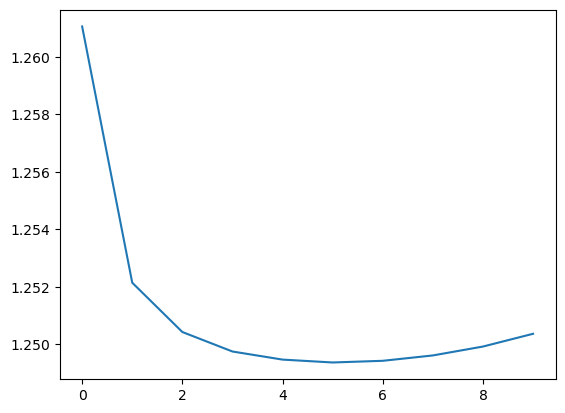

In [108]:
# plt.plot(results["train_loss"])
plt.plot(results["test_loss"])